# CPSC 599.87 - Clustering Exercise
*(Original Notebook from Eytan Adar's SI 370 course — University of Michigan)*

## Objectives:
- Be able to perform hierarchical clustering and k-means clustering.
- Know how and when to use different similarity functions, including Euclidean, Manhattan, Jaccard, and Cosine.
- Be able to appropriately evaluate clustering results, with or without ground truth.
- Be able to determine the number of clusters given a dataset without ground truth.

In [1]:
# Filter all warnings.
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

# 1. Hierarchical Clustering

Let's start with a toy dataset that has two dimensions. There are three obvious clusters.

Reference: https://github.com/herrfz/dataanalysis

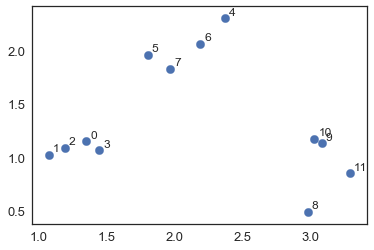

In [3]:
np.random.seed(0)
x = np.random.randn(12) * 0.2 + np.repeat(np.arange(3)+1, 4)
y = np.random.randn(12) * 0.2 + np.repeat(np.array([1,2,1]), 4)
plt.scatter(x, y, s=70)
for i, xi in enumerate(x):
    plt.annotate(str(i), (xi+0.03, y[i]+0.03), fontsize=12)

In [11]:
# Let's create a DataFrame.
df_xy = pd.DataFrame({'x': x, 'y': y})
df_xy

,x,y
0,1.352810,1.152208
1,1.080031,1.024335
2,1.195748,1.088773
3,1.448179,1.066735
4,2.373512,2.298816
5,1.804544,1.958968
6,2.190018,2.062614
7,1.969729,1.829181
8,2.979356,0.489402
9,3.082120,1.130724


In [5]:
# To perform hierarchical clustering, the first step is to compute 
# the distance matrix. We will be using the Euclidean distance.
dist_xy = spd.squareform(spd.pdist(df_xy, metric='euclidean'))
dist_xy.shape

(12, 12)

In [6]:
# The matrix may be too large to display. So let's display a top-left
# portion of it.
dist_xy[:4,:4]

array([[ 0.        ,  0.30126365,  0.16938929,  0.12806509],
       [ 0.30126365,  0.        ,  0.13244787,  0.37058077],
       [ 0.16938929,  0.13244787,  0.        ,  0.25339119],
       [ 0.12806509,  0.37058077,  0.25339119,  0.        ]])

Notice that in the matrix above, the diagnonal values are 0, which is
expected: an object's distance to itself must be 0.

Before performing hierarchical clustering, let us review an important concept, "linkage function."
 - For hierarchical clustering, a _linkage function_ is a distance function between two clusters. In scipy multiple different linkage functions are implemented, including single, complete, average, weighted, centroid, median, and ward. We will be using "single", which is taking the distance between two nearest points as the distance between two clusters. This is the default option. See [scipy documentation](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.cluster.hierarchy.linkage.html) for more details.

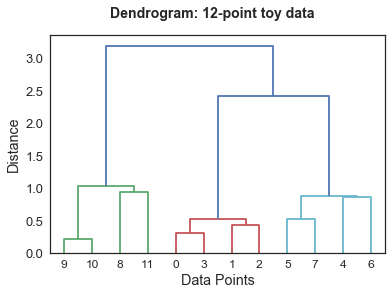

In [7]:
# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(dist_xy, method='single')  # obtain the linkage matrix
_ = sph.dendrogram(Z_xy)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In the above dendrogram, the y-axis depicts the distance at which a cluster is formed. This distance is obtained by evaluating the linkage function. We can see that the green cluster forms at around 1.0, then the next cluster forms at around 2.4. There is a large gap (on the y-axis) in between, which indicates that segmenting the data there may be a good choice. In fact, the scipy package automatically selects a threshold, below which the clusters are colored differently, and above which the clusters are all colored blue. This happens to match our interpretation.

Based on the above analysis, 2.0 seems to be a good distance threshold to "clip" the dendrogram and obtain our clustering results. The way to apply the clipping threshold is as follows:

In [ ]:
cluster_labels = sph.fcluster(Z_xy, 2.0, criterion='distance')
df_xy['cluster_label'] = cluster_labels
df_xy

Compare the cluster_labels with the scatterplot at the beginning, we can see that hierarchical clustering indeed captures the actual clusters as expected.

Now it is your turn. Do the following exercise.

## Exercise:
- Step 1: Import the Iris dataset and create a scatterplot, showing petal_lengths and petal_widths.
- Step 2: Compute the distance matrix among irises using petal_lengths and petal_widths. Use Euclidean distance.
- Step 3: Perform hierarchical clustering.
- Step 4: Pick a distance threshold that results in 3 clusters that match the actual number of species.

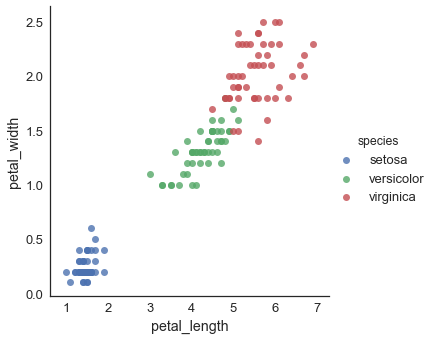

In [8]:
# Step 1: Import the iris dataset and create scatterplot.
# Show only petal_length and petal_width.
df_iris = sns.load_dataset('iris')
sns.lmplot(x='petal_length', y='petal_width', hue='species', 
           fit_reg=False, data=df_iris);

In [9]:
# Step 2: Compute distance matrix. Using petal_length and petal_width only.
# plpw means "petal_length and petal_width"
dist_iris_plpw = spd.squareform(spd.pdist(
        df_iris[['petal_length', 'petal_width']], 
        metric='euclidean'))
dist_iris_plpw.shape

(150, 150)

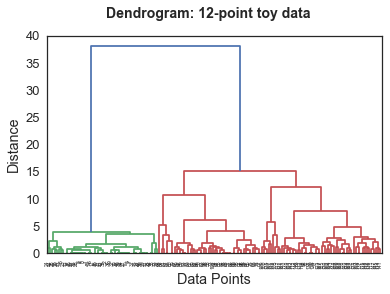

In [10]:
# Perform hierarchical clustering and plot the dendrogram.
iris_xy = sph.linkage(dist_iris_plpw, method='average')  # obtain the linkage matrix
_ = sph.dendrogram(iris_xy)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In [ ]:
# Add  labels back to the dataframe
iris_labels = sph.fcluster(iris_xy, 2.0, criterion='distance')
df_iris['cluster_label'] = iris_labels
df_iris.head()

In [ ]:
# Plot
sns.lmplot(x='petal_length', y='petal_width', hue='cluster_label', 
           fit_reg=False, data=df_iris);

# 2. k-means

In [ ]:
# Let's first revisit the 12-point toy dataset.
plt.scatter(df_xy.x, df_xy.y, s=70)
for i, xi in enumerate(df_xy.x):
    plt.annotate(str(i), (xi+0.03, df_xy.y[i]+0.03))

In [ ]:
df_xy

In [ ]:
# Perform k-means using the scikit-learn package
kmeans_model = skc.KMeans(n_clusters=3)
kmeans_model.fit(df_xy)
centroids = kmeans_model.cluster_centers_
centroids  # these are the centers of the clusters

In [ ]:
# See cluster_labels
kmeans_model.labels_

In [ ]:
# Plot the clusters with their centroids.
df_xy['cluster_labels_kmeans'] = kmeans_model.labels_
f = sns.lmplot(x='x', y='y', data=df_xy, hue='cluster_labels_kmeans',
               fit_reg=False, size=5, aspect=1.3)
f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
             linewidths=2, color='k');
plt.title('12-point dataset with K-means centroids (k=3)', fontsize=15)

# 3. Distance Metrics

In [ ]:
traits = [
    ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),
    ('Bob', ['Strong', 'Confident', 'Creative','Tidy']),
    ('Charlie', ['Confident', 'Strong', 'Accessible', 'Sweet']),
    ('Dacy', ['Accessible', 'Strong', 'Tidy', 'Confident']),
    ('Emily', ['Reserved', 'Cute', 'Quiet', 'Impassive']),
    ('Fred', ['Cute', 'Impassive', 'Gentle','Confident']),
    ('George', ['Cute', 'Quiet', 'Reserved', 'Confident'])
]

In [ ]:
# In order to make computation easier, let's create dummy variables 
# for traits. You should be able to understand what is going on below.

# First, obtain a unique list of traits.
all_traits = sorted({t for x in traits for t in x[1]})

# Second, create dummy variables.
traits_dummy = []
for name, ts in traits:
    tis = [0] * len(all_traits)
    for t in ts:
        tis[all_traits.index(t)] = 1
    traits_dummy.append(tis)

# Third, create a DataFrame.
names = [x[0] for x in traits]
df_traits = pd.DataFrame(traits_dummy, columns=all_traits, index=names)
df_traits

In [ ]:
kmeans_model = skc.KMeans(n_clusters=3)
kmeans_model.fit(df_traits)
centroids = kmeans_model.cluster_centers_
centroids

In [ ]:
kmeans_model.labels_

Let's try different distance measures between Alice and Bob.
We've copied their traits down here:

 ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),

 ('Bob', ['Strong', 'Confident', 'Creative','Sporting']),

Notice they have 4 traits each and they share 2 traits in common.

In [ ]:
# (1) Euclidean distance:
#     by definition, this will be sqrt(1^2 + 1^2 + 1^2 + 1^2)
spd.euclidean(df_traits.loc['Alice'], df_traits.loc['Bob'])

In [ ]:
# (2) Jaccard distance:
#     by definition, this will be 1 - (2 / 6)
spd.jaccard(df_traits.loc['Alice'], df_traits.loc['Bob'])

In [ ]:
# (3) Manhattan (cityblock) distance:
#     by definition, this will be 1 + 1 + 1 + 1
spd.cityblock(df_traits.loc['Alice'], df_traits.loc['Bob'])

In [ ]:
# (4) Cosine distance
#     by definition, this will be 1 - 2 / (2 * 2)
spd.cosine(df_traits.loc['Alice'], df_traits.loc['Bob'])

In [ ]:
# As we have seen in Section 1, you can compute pairwise distance like
# below, using any of the distance measurements. 
dist_traits = spd.squareform(spd.pdist(df_traits, 'cosine'))
dist_traits[:4,:4]  # to save space, only show the top left 4x4 block

# 4. Determining the Number of Clusters

A number of clustering methods, such as k-means, assumes the parameter _k_ (#clusters) is known in advance, which is often not the case in practice. A number of techniques exist for determining the number of clusters in a dataset. See [this Wikipedia page](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#Information_Criterion_Approach) for a detailed discussion.

In this section, we focus on four of the approaches:
1. Rule of thumb
2. The Elbow Method

For this section, let us use `df_xy`, the dataset we created in Section 1. Obviously, there are 3 natural clusters in the dataset. Let us see if all the methods listed above will be able to recover the true number of clusters.

## 4.1 Rule of thumb:
Choosing the number of clusters to simply be

$$
k \approx \sqrt{n/2}
$$

where $n$ is the number of observations.

In [ ]:
# Recall df_xy used in the first section.
plt.scatter(df_xy.x, df_xy.y)

In [ ]:
# To determine the natural cluster
np.sqrt(len(df_xy) / 2)

In [ ]:
# Round this number to an integer
np.round(np.sqrt(len(df_xy) / 2))

This is not what we desired. We wanted k to be 3.

## 4.2 The Elbow Method
See [here](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method) for an explanation.

Implementation Reference: https://github.com/nborwankar/LearnDataScience

In [ ]:
X = df_xy.iloc[:,:2]  # Using the the dataset of Section 1
K = range(1,11)  # Apply kmeans 1 to 10
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

According to the graph above, the "within-cluster sum of squares" (i.e., within-cluster variance) reduces as the number of clusters (k) grows. However, as k grows larger, the marginal reduction drops. At some point, this drop is so obvious that it forms a visible "angle" in the graph. The number of clusters is then chosen at this point, hence the "elbow" criterion". The "elbow" is not always easily identifiable.

In the above plot, we can manually identify k=3 as the "elbow" point.

# References
- Coursera Jeff Leek's "Data Analysis" Course Notes: https://github.com/herrfz/dataanalysis
- Scikit-learn clustering tutorial: http://scikit-learn.org/stable/modules/clustering.html
- Manning et al. ["Evaluation of Clustering"](http://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html). _Introduction to Information Retrieval_ (2008).